In [1]:
import os
from typing import List, Tuple, Union, Optional
import numpy as np
import PIL.Image

import torch
import torch.nn.functional as F
import functools

import dnnlib
import legacy

from torch_utils import gen_utils

In [2]:
device = torch.device('cuda') 

In [3]:
network_pkl = 'models/anime_faces_latest.pkl'
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

In [4]:
#I copied the various functions from gen_utils for easy reference

def w_to_img(G, dlatents: Union[List[torch.Tensor], torch.Tensor], noise_mode: str = 'const') -> np.ndarray:
    """
    Get an image/np.ndarray from a dlatent W using G and the selected noise_mode. The final shape of the
    returned image will be [len(dlatents), G.img_resolution, G.img_resolution, G.img_channels].
    """
    assert isinstance(dlatents, torch.Tensor), f'dlatents should be a torch.Tensor!: "{type(dlatents)}"'
    if len(dlatents.shape) == 2:
        dlatents = dlatents.unsqueeze(0)  # An individual dlatent => [1, G.mapping.num_ws, G.mapping.w_dim]
    try:
        synth_image = G.synthesis(dlatents, noise_mode=noise_mode)
    except:
        synth_image = G.synthesis(dlatents, noise_mode=noise_mode, force_fp32=True)
    
    synth_image = (synth_image + 1) * 255/2  # [-1.0, 1.0] -> [0.0, 255.0]
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()  # NCWH => NWHC
    return synth_image

def get_w_from_seed(G, device: torch.device, seed: int, truncation_psi: float) -> torch.Tensor:
    """Get the dlatent from a random seed, using the truncation trick (this could be optional)"""
    z = np.random.RandomState(seed).randn(1, G.z_dim)
    w = G.mapping(torch.from_numpy(z).to(device), None)
    w_avg = G.mapping.w_avg
    w = w_avg + (w - w_avg) * truncation_psi

    return w

def get_w_from_mean_z(G, device: torch.device, truncation_psi: float) -> torch.Tensor:
    """Get the dlatent from the mean z space"""
    w = G.mapping(torch.zeros((1, G.z_dim)).to(device), None)
    w_avg = G.mapping.w_avg
    w = w_avg + (w - w_avg) * truncation_psi

    return w

def get_w_from_mean_w(G, device: torch.device, seed: int, truncation_psi: float) -> torch.Tensor:
    """Get the dlatent of the mean w space"""
    w = G.mapping.w_avg.unsqueeze(0).unsqueeze(0).repeat(1, 16, 1).to(device)
    return w

def _parse_cols(s: str, G, device: torch.device, truncation_psi: float) -> List[torch.Tensor]:
    """s can be a path to a npy/npz file or a seed number (int)"""
    s = s.split(',')
    w = torch.Tensor().to(device)
    for el in s:
        if os.path.isfile(el):
            w_el = gen_utils.get_w_from_file(el)  # np.ndarray
            w_el = torch.from_numpy(w_el).to(device)  # torch.tensor
            w = torch.cat((w_el, w))
        else:
            nums = gen_utils.num_range(el)
            for n in nums:
                w = torch.cat((gen_utils.get_w_from_seed(G, device, n, truncation_psi), w))
    return w

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


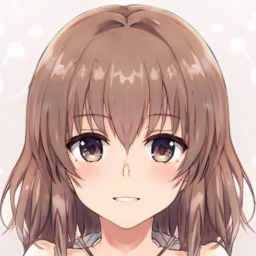

Setting up PyTorch plugin "bias_act_plugin"... Done.


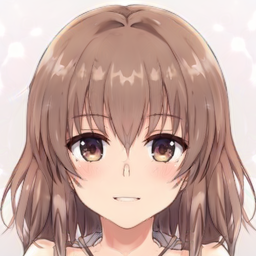

In [5]:
#Shows the most generic anime girl with either the z space set to zero or the mean w space
w = get_w_from_mean_w(G,device,1,1.)
img = w_to_img(G,w,'none')
display(PIL.Image.fromarray(img.squeeze(0), 'RGB'))

w_mean = get_w_from_mean_z(G,device,.1)
img = w_to_img(G,w_mean,'none')
display(PIL.Image.fromarray(img.squeeze(0), 'RGB'))

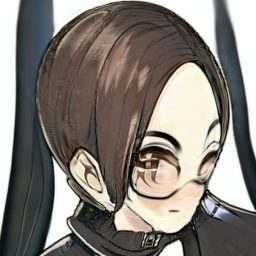

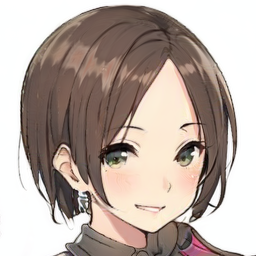

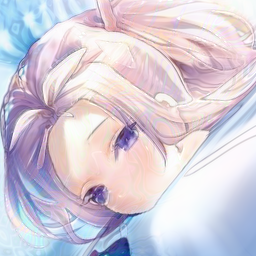

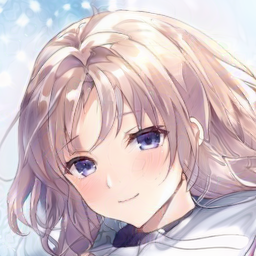

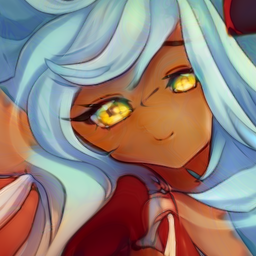

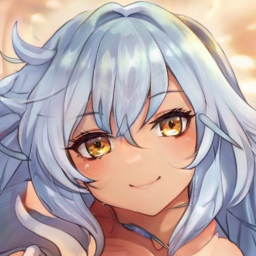

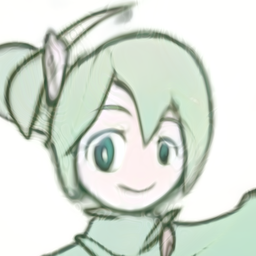

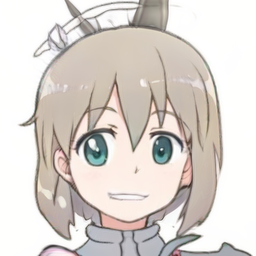

In [6]:
#Truncation Trick examples
#Uses five random z spaces compared using truncation_psi as 0.7 and 1.5
for i in range(4):
    w1 = get_w_from_seed(G,device,i,1.5)
    w2 = get_w_from_seed(G,device,i,0.7)
    
    img1 = w_to_img(G,w1,'none')
    img2 = w_to_img(G,w2,'none')
    
    display(PIL.Image.fromarray(img1.squeeze(0), 'RGB'))
    display(PIL.Image.fromarray(img2.squeeze(0), 'RGB'))

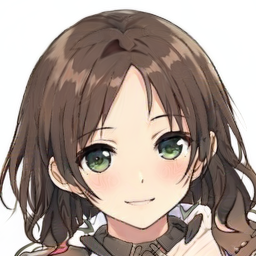

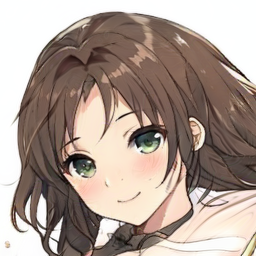

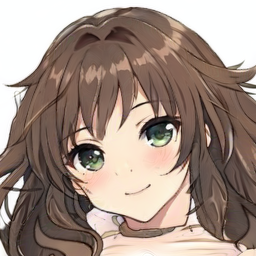

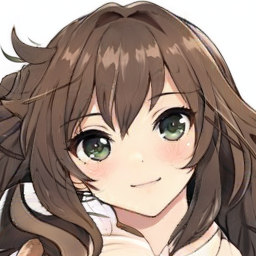

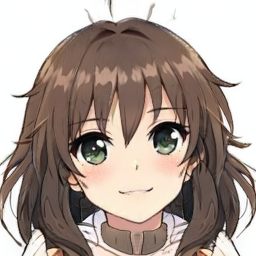

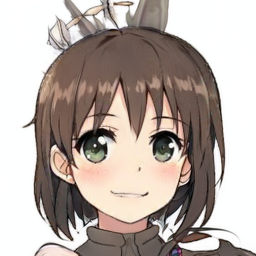

In [7]:
#Style Mixing
#Example showing fundamental style mix
truncation_psi = 0.7
w_avg = G.mapping.w_avg
w_list = []

for i in range(4):
    z = np.random.RandomState(i).randn(1, G.z_dim)
    w = G.mapping(torch.from_numpy(z).to(device), None)
    w = w_avg + (w - w_avg) * truncation_psi
    w_list.append(w)

w_base = w_list[0].clone()
for i in range(1,4):
    w_base[:,:7,:] = (w_list[i][:,:7,:]+w_base[:,:7,:])*.5
    img1 = w_to_img(G,w_base,'none')
    display(PIL.Image.fromarray(img1.squeeze(0), 'RGB'))
    w_base[:,:7,:] = w_list[i][:,:7,:]
    img2 = w_to_img(G,w_base,'none')
    display(PIL.Image.fromarray(img2.squeeze(0), 'RGB'))

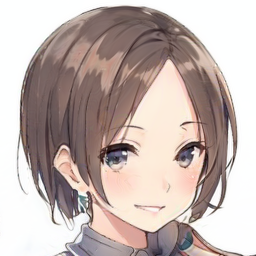

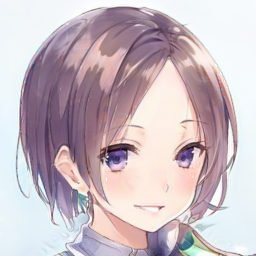

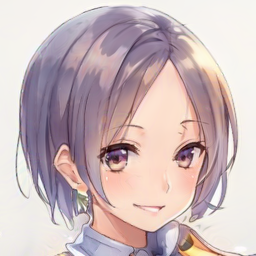

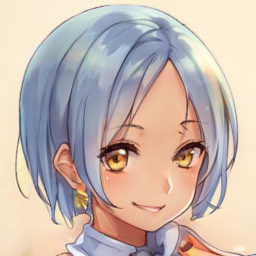

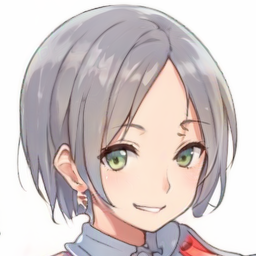

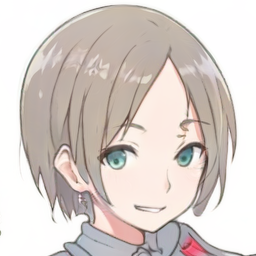

In [8]:
#Style Mixing
#Example showing fine style mix
w_base = w_list[0].clone()
for i in range(1,4):
    w_base[:,8:,:] = (w_list[i][:,8:,:]+w_base[:,8:,:])*.5
    img1 = w_to_img(G,w_base,'none')
    display(PIL.Image.fromarray(img1.squeeze(0), 'RGB'))
    w_base[:,8:,:] = w_list[i][:,8:,:]
    img2 = w_to_img(G,w_base,'none')
    display(PIL.Image.fromarray(img2.squeeze(0), 'RGB'))

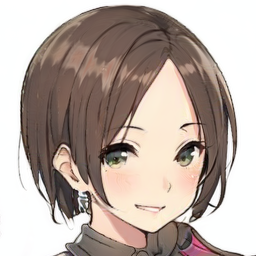

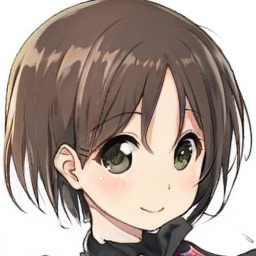

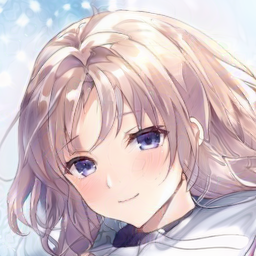

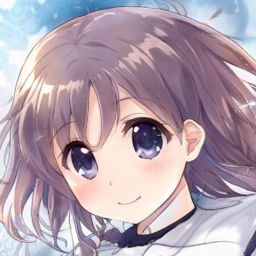

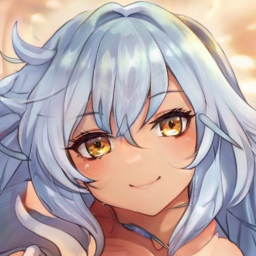

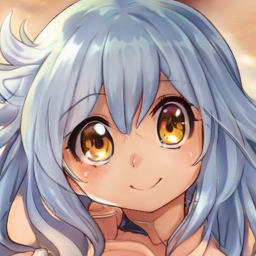

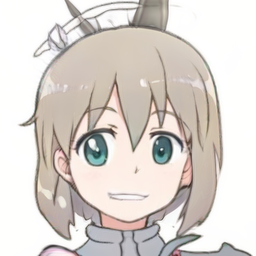

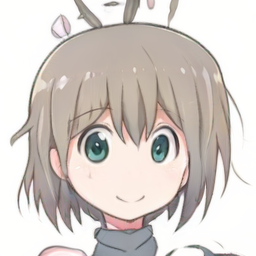

In [9]:
#Projection
#Example showing a style mix with the hero image
w_input_loc = 'models/wide_eye_w.npy'
input_w = _parse_cols(w_input_loc, G, device, 0.7)

for i in range(4):
    
    w = get_w_from_seed(G,device,i,0.7)
    output_w = w.clone()
    output_w[:,6,:] = input_w[:,6,:]
    output_w[:,7,:] = input_w[:,7,:]
    img_in = w_to_img(G,w,'none')
    img_out = w_to_img(G,output_w,'none')
    
    display(PIL.Image.fromarray(img_in.squeeze(0), 'RGB'))
    display(PIL.Image.fromarray(img_out.squeeze(0), 'RGB'))

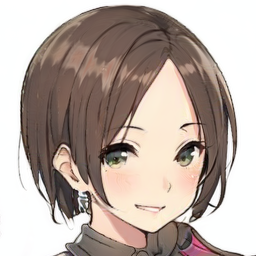

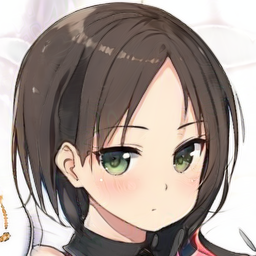

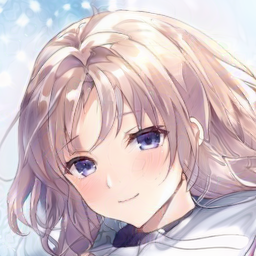

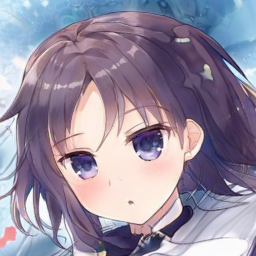

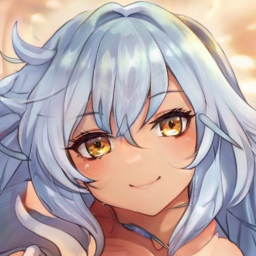

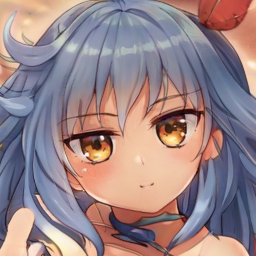

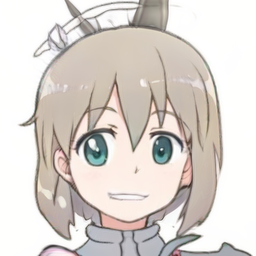

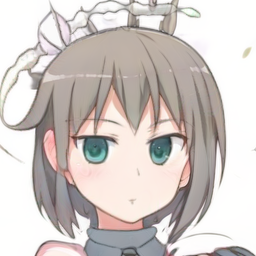

In [10]:
#Projection
#Example showing a style mix with the villain image
w_input_loc = 'models/narrow_eye_w.npy'
input_w = _parse_cols(w_input_loc, G, device, 0.7)

for i in range(4):
    
    w = get_w_from_seed(G,device,i,0.7)
    output_w = w.clone()
    output_w[:,6,:] = input_w[:,6,:]
    output_w[:,7,:] = input_w[:,7,:]
    img_in = w_to_img(G,w,'none')
    img_out = w_to_img(G,output_w,'none')
    
    display(PIL.Image.fromarray(img_in.squeeze(0), 'RGB'))
    display(PIL.Image.fromarray(img_out.squeeze(0), 'RGB'))